Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [29]:
%cd /Users/ezb/Jupyter notebooks/datasets

/Users/ezb/Jupyter notebooks/datasets


In [73]:
import pandas as pd 

df = pd.read_csv("DC_Properties.csv", low_memory=False)

In [74]:
def datawrangle(x):
    # make copy
    x = x.copy()

    # drop X and Y because they're the same as LONGITUDE and LATITUDE
    x = x.drop(columns=['X', 'Y'])

    # drop redundant or useless columns
    x = x.drop(columns=['Unnamed: 0', 'STATE', 'CITY', 'SOURCE', 'FULLADDRESS', 'NATIONALGRID'])

    # drop null values in price since that's our target
    x = x.dropna(subset=['PRICE'], how='any')

    return x

df = datawrangle(df)

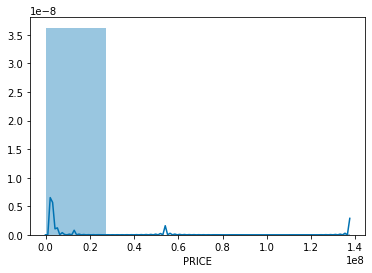

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')

sns.distplot(df['PRICE'], bins=5)

plt.show()

In [76]:
df.shape

(98216, 41)

In [77]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import category_encoders as ce

target = 'PRICE'

x = df.drop(columns=target)
y = df[target]

x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=20000, random_state=0
)

x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=20000, 
    random_state=0
)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100,
                          random_state=0,
                          n_jobs=-1
    )
)

pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['HEAT', 'AC', 'SALEDATE', 'QUALIFIED',
                                      'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
                                      'EXTWALL', 'ROOF', 'INTWALL',
                                      'GIS_LAST_MOD_DTTM', 'ASSESSMENT_NBHD',
                                      'ASSESSMENT_SUBNBHD', 'CENSUS_BLOCK',
                                      'WARD', 'SQUARE', 'QUADRANT'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'HE...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease

In [78]:
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

Train Accuracy 0.999059297489603
Validation Accuracy 0.9965363729382508


In [86]:
import numpy as np

y_pred_train = pipeline.predict(x_train)
y_pred_val = pipeline.predict(x_val)
    
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Validation Root Mean Square Error:', np.sqrt(mean_squared_error(y_val, y_pred_val)))
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Validation Mean Absolute Error:', mean_absolute_error(y_val, y_pred_val))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Validation R^2 Score:', r2_score(y_val, y_pred_val))

Train Root Mean Squared Error: 214956.16433201364
Validation Root Mean Square Error: 447380.4140177815
Train Mean Absolute Error: 43592.05434617877
Validation Mean Absolute Error: 119905.69256841192
Train R^2 Score: 0.999059297489603
Validation R^2 Score: 0.9965363729382508


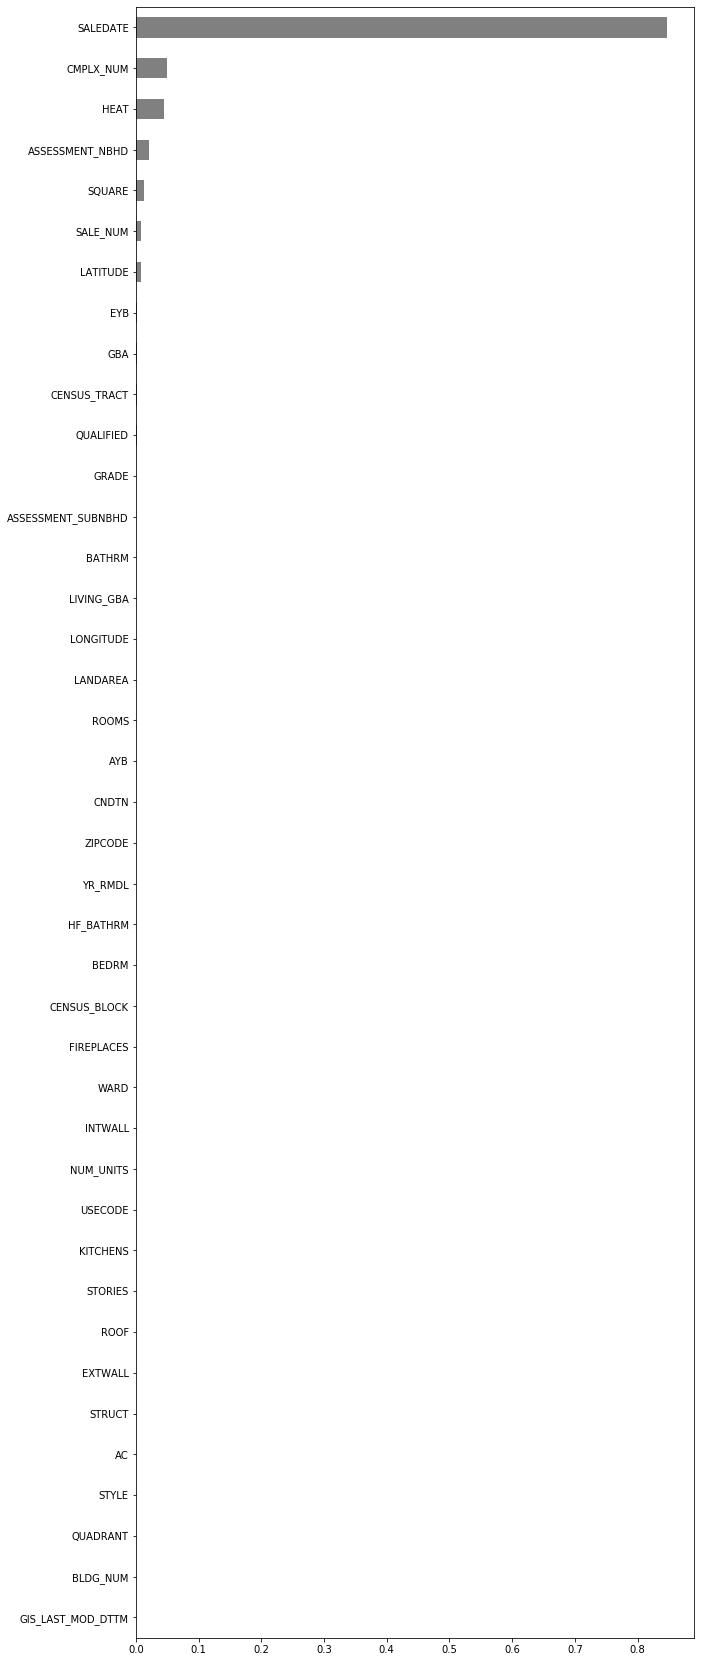

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')

model = pipeline.named_steps['randomforestregressor']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(x_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [87]:
y_pred_train = pipeline.predict(x_train)
y_pred_test = pipeline.predict(x_test)

print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Test R^2 Score:', r2_score(y_test, y_pred_test))

Train Root Mean Squared Error: 214956.16433201364
Test Root Mean Square Error: 505168.751751513
Train Mean Absolute Error: 43592.05434617877
Test Mean Absolute Error: 125688.93460234406
Train R^2 Score: 0.999059297489603
Test R^2 Score: 0.9942126207312983


In [103]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)

model = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(x_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [105]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=2, 
    random_state=0
)

permuter.fit(x_val_transformed, y_val)
feature_names = x_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [95]:
%%time 

from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(
        n_estimators=100, 
        random_state=0, 
        n_jobs=-1
    )
)

pipeline.fit(x_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:08:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 24.4 s, sys: 266 ms, total: 24.7 s
Wall time: 7.57 s


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['HEAT', 'AC', 'SALEDATE', 'QUALIFIED',
                                      'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
                                      'EXTWALL', 'ROOF', 'INTWALL',
                                      'GIS_LAST_MOD_DTTM', 'ASSESSMENT_NBHD',
                                      'ASSESSMENT_SUBNBHD', 'CENSUS_BLOCK',
                                      'WARD', 'SQUARE', 'QUADRANT'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'HE...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                          

In [96]:
y_pred_train = pipeline.predict(x_train)
y_pred_val = pipeline.predict(x_val)
    
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Validation Root Mean Square Error:', np.sqrt(mean_squared_error(y_val, y_pred_val)))
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Validation Mean Absolute Error:', mean_absolute_error(y_val, y_pred_val))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Validation R^2 Score:', r2_score(y_val, y_pred_val))

Train Root Mean Squared Error: 749083.276909653
Validation Root Mean Square Error: 782764.2229114245
Train Mean Absolute Error: 222268.81718242372
Validation Mean Absolute Error: 235173.3490565201
Train R^2 Score: 0.9885761445704656
Validation R^2 Score: 0.989396746974939
